# Class for Radial Basis Function - Neural Network

In [90]:
import numpy as np
import pickle
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans


# -------------------------------------------------------------------------------------------------
#       Radial Basis Function (RBF) - Neural Network
# -------------------------------------------------------------------------------------------------
class RBF_Neural_Nw ():
    def __init__ (self, size_input_features = 0, size_hidden = 0, size_out = 0, radial_function = "Gaussian Kernel", loss_function = "Mean Square Error", spread = 0, center_method = "Random"):
        # Number of features in each input
        self.size_input_features = size_input_features

        # Number of neurons in the hidden layer
        self.size_hidden = size_hidden
        
        # Number of neurons in the output layer
        self.size_out = size_out

        # Radial Function Object (To be used at the hidden layer)
        self.radial = Radial(radial_function)

        # Loss Object
        self.loss = Loss(loss_function)

        # Weights from hidden-to-output layer
        self.weights = np.random.randn(self.size_hidden, self.size_out)

        # Output Arrays - for actual computed values
        self.actual_in = None
        self.G = None
        self.actual_out = None

        # Spread(s) for radial functions (at the hidden layer)
        self.spread_concrete = spread
        self.spreads = None

        # Center(s) for radial functions (at the hidden layer)
        self.center_method = center_method
        self.centers = np.empty(self.size_hidden)


    # Starting Point - To Build the Model
    def build_Model (self,test_input_set, validation_input_set, test_label_set, validation_label_set):        
        # -------------- Create Radial Basis Function (RBF) Network - Model -----------------
        loss = self.train_RBF(test_input_set.T, test_label_set.T)
        # ------------------------------------------------------------

        # -------------- Test and Validate the model -----------------
        print("\n\n\t\t\t Spread = " + str(self.spread_concrete))
        print("\t-----------------------------------------------------")
        print("\tMean Square Error:\t\t" + str(loss))

        accuracy_predictions_test = accuracy(test_label_set, self.predict(test_input_set.T).T) * 100
        print("\tAccuracy of Test Set: \t\t" + str(accuracy_predictions_test))

        accuracy_predictions_valid = accuracy(validation_label_set, self.predict(validation_input_set.T).T) * 100
        print("\tAccuracy of Validation Set:\t" + str(accuracy_predictions_valid))
        # ------------------------------------------------------------

        return loss, accuracy_predictions_test, accuracy_predictions_valid
    

    # Function to train the model with given patterns
    def train_RBF (self, test_input_set, test_label_set):
        # print("Training for " + str(len(test_input_set)) + " inputs:")
        # Step 1 - Apply Input Pattern
        self.actual_in = np.array(test_input_set, dtype=float)

        # Step 2: Unsupervised Clustering Stage
        self.unsupervised_clustering()
        
        # Step 3: Supervised Learning Stage
        self.weights = np.dot(np.dot(np.linalg.pinv(np.dot(self.G, self.G.T)), self.G), test_label_set.T)
        # self.weights = np.dot(np.dot(np.linalg.pinv(np.dot(self.G, self.G.T)), self.G), test_label_set.T)

        # Step 4 - Find the values at output layer
        self.actual_out = np.dot(self.weights.T, self.G)

        # Step 5: Calculate Loss
        loss = self.loss.loss_function(test_label_set, self.actual_out)

        return loss
    

    # For Testing and Validation Purpose
    def predict (self, input):
        # print("Predicting for " + str(len(input)) + " inputs:")
        # Step 1 - Apply Input Pattern
        self.actual_in = np.array(input, dtype=float)
    
        # Step 2: Apply Radial Function
        self.G = np.array(self.apply_radial_function())

        # Step 3 - Find the values at output layer
        self.actual_out = np.dot(self.weights.T, self.G)

        return signum(self.actual_out)
    

    # Step 2 - Unsupervised Clustering Stage
    def unsupervised_clustering (self):
        # Find Centers of Radial Functions at hidden layer
        if self.center_method == "Input":
            self.centers = self.actual_in.T
        elif self.center_method == "Random Inputs":
            self.centers = self.actual_in.T[np.random.choice(len(self.actual_in.T), size = self.size_hidden, replace = False)]
        elif self.center_method == "K-Means":
            kmeans = KMeans(n_clusters = self.size_hidden, random_state = 0).fit(self.actual_in.T)
            self.centers = kmeans.cluster_centers_
        elif self.center_method == "Class Example":
            self.centers = np.array([[0, 0], [1,1]], dtype = float)
            # self.centers = self.actual_in.T

        # Find Centers of Radial Functions at hidden layer
        self.spreads = np.ones(self.size_hidden) * self.spread_concrete

        # Apply Radial Function
        self.G = np.array(self.apply_radial_function())


    def apply_radial_function (self):
        G = np.empty([self.size_hidden, len(self.actual_in[0])]).T
        for i in range(len(self.actual_in[0])):
            G[i] = self.radial.radial_function(self.actual_in.T[i], self.spreads, self.centers)
        
        # G1 = np.empty([self.size_hidden, len(self.actual_in[0])])
        # for i in range(self.size_hidden):
        #     for j in range(len(self.actual_in[0])):
        #         G1[i][j] = self.radial.radial_function(self.actual_in.T[j], self.spreads[i], self.centers[i])

        return G.T


    # Function to save the model as an object - on disk
    def saveModel(self, file_name):
        with open(file_name, 'wb') as pk_object:
            pickle.dump(self, pk_object, pickle.HIGHEST_PROTOCOL)

    # Function to read the model - already available on disk
    def retrieveModel(self, file_name):
        rbf_model = None

        with open(file_name, 'rb') as pk_object:
            rbf_model = pickle.load(pk_object)

        return rbf_model
# -------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------



# -------------------------------------------------------------------------------------------------
#       Class - to group all Radial Functions
# -------------------------------------------------------------------------------------------------
class Radial ():
    def __init__ (self, f_name):
        self.f_name = f_name

    # -------------- Navigator Function -----------------
    def radial_function (self, input, spread, center):
        if (self.f_name == "Gaussian Kernel"):
            return self.gaussianKernel(input, spread, center)
        elif (self.f_name == "Logistic"):
            return self.logistic(input, spread, center)


    # -------------- Gaussian Kernel Function -----------------
    def gaussianKernel (self, input, spread, center):
        euclidean_square = np.power(self.find_Euclidian_Distance(input, center), 2)
        two_sigma_square = 2 * np.power(spread, 2)

        return np.exp(- euclidean_square / two_sigma_square)


    # -------------- Logistic Function -----------------
    def logistic (self, input, spread, center):
        euclidean_square = np.power(self.find_Euclidian_Distance(input, center), 2)
        two_sigma_square = 2 * np.power(spread, 2)

        return (1 / ( 1 + np.exp(euclidean_square / two_sigma_square)))


    # -------------- Function to find the Eclidean Distance -----------------
    def find_Euclidian_Distance (self, src, dest):
        return np.sqrt(np.sum(np.square(src - dest), axis = 1))
# -------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------




# -------------------------------------------------------------------------------------------------
#       Class - to group all Loss Functions
# -------------------------------------------------------------------------------------------------
class Loss ():
    def __init__ (self, f_name):
        self.f_name = f_name

    def loss_function (self, expected, actual):
        if (self.f_name == "Mean Square Error"):
            return self.meanSquareErrorLoss(expected, actual)

    def meanSquareErrorLoss (self, expected, actual):
        return (np.sum(np.power(expected.T - actual.T, 2))) / len(expected.T)
# -------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------



# -------------------------------------------------------------------------------------------------
#           Other Functions
# -------------------------------------------------------------------------------------------------
def signum (input):
    return np.where(input >= 0, 1, -1)
# -------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------



# -------------------------------------------------------------------------------------------------
#       Accuracy Function (Source: Assignment 1 - Zip (LEARN, uWaterloo))
# -------------------------------------------------------------------------------------------------
def accuracy(y_true, y_pred):
    if not (len(y_true) == len(y_pred)):
        print('Size of predicted and true labels not equal.')
        return 0.0

    corr = 0
    for i in range(0,len(y_true)):
        corr += 1 if (y_true[i] == y_pred[i]).all() else 0

    return corr/len(y_true)
# -------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------

#### Assignment-specific functions

In [91]:
# -------------------------------------------------------------------------------------------------
#               Class - to group together assignment-specific functions
# -------------------------------------------------------------------------------------------------
class assignment ():
    def __init__ (self, center_methods, spreads, test_validation_division = 9/10):
        self.center_methods = center_methods
        self.spreads = spreads
        self.test_validation_division = test_validation_division

        self.test_input_set = None
        self.validation_input_set = None
        self.test_label_set = None
        self.validation_label_set = None

    
    def generate_input_data (self):
        # Input to the Network
        training_input = np.empty([21, 21, 2], dtype = float)
        training_label = np.empty([21, 21], dtype = float)

        for i in range(len(training_input)):
            for j in range(len(training_input[0])):
                training_input[i, j] = np.array([-2 + (0.2 * i), -2 + (0.2 * j)])

                if (np.power(training_input[i, j, 0], 2) + np.power(training_input[i, j, 1], 2)) <= 1:
                    training_label[i, j] = 1
                else:
                    training_label[i, j] = -1

        training_input = np.array(training_input.reshape(len(training_input) * len(training_input[0]), 2))
        training_label = np.array([training_label.reshape(len(training_label) * len(training_label[0]))]).T

        # Split the data into test and validation sets        
        self.test_input_set, self.validation_input_set, self.test_label_set, self.validation_label_set = train_test_split(training_input, training_label, test_size=(1 - self.test_validation_division), random_state=40)


    def train_and_observe (self):
        # Train the network for different configurations and compare them
        config, plot = pyplot.subplots(3, 3)
        config.set_size_inches(3* 7, 3 * 7)

        x = 0
        results = []
        for cm in self.center_methods:
            track_progress = np.empty([len(self.spreads), 4])

            centers = len(self.test_input_set)
            if cm in ["Random Inputs", "K-Means"]:
                centers = 150

            print("\n\n\n----------------------------------------------------------------------------------------------------------------")
            print("\t\t\t Centers are found using - " + cm + " and with " + str(centers) + " neurons in the hidden layer")
            print("----------------------------------------------------------------------------------------------------------------")

            for i in range(len(self.spreads)):
                # Train the network
                rbf = RBF_Neural_Nw(size_input_features = 2, size_hidden = centers, size_out = 1, radial_function = "Gaussian Kernel", loss_function = "Mean Square Error", spread = self.spreads[i], center_method = cm)
                loss, accuracy_predictions_test, accuracy_predictions_valid = rbf.build_Model(self.test_input_set, self.validation_input_set, self.test_label_set, self.validation_label_set)

                track_progress[i] = [self.spreads[i], loss, accuracy_predictions_test, accuracy_predictions_valid]
            
            results.append(track_progress)

            plot[x, 0].set_title("Centers are found using - " + cm + " and with " + str(centers) + " neurons in the hidden layer")
            plot[x, 0].set_xlabel("Spread")
            plot[x, 0].set_ylabel("MSE")
            plot[x, 0].plot(track_progress.T[0], track_progress.T[1])
            # plot[x, 0].set_show()

            plot[x, 1].set_xlabel("Spread")
            plot[x, 1].set_ylabel("Training Accuracy")
            plot[x, 1].plot(track_progress.T[0], track_progress.T[2])
            # plot[x, 1].set_show()

            plot[x, 2].set_xlabel("Spread")
            plot[x, 2].set_ylabel("Validation Accuracy")
            plot[x, 2].plot(track_progress.T[0], track_progress.T[3])
            # plot[x, 2].show()

            x += 1

        pyplot.show()


        # Plot cumulative Graph
        config_cum, plot_cum = pyplot.subplots(1, 3)
        config_cum.set_size_inches(3 * 8, 7)

        plot_cum[0].set_xlabel("Spread")
        plot_cum[0].set_ylabel("MSE")

        plot_cum[1].set_xlabel("Spread")
        plot_cum[1].set_ylabel("Training Accuracy")

        plot_cum[2].set_xlabel("Spread")
        plot_cum[2].set_ylabel("Validation Accuracy")

        for i in range(len(results)):
            plot_cum[0].plot(results[i].T[0], results[i].T[1])
            plot_cum[1].plot(results[i].T[0], results[i].T[2])
            plot_cum[2].plot(results[i].T[0], results[i].T[3])

        pyplot.figlegend(['Centers = Input', 'Centers = 150 Random inputs', 'Centers = 150 K-Means'], loc='upper left')
        pyplot.show()
# -------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------



# Train and observe the Network




----------------------------------------------------------------------------------------------------------------
			 Centers are found using - Input and with 352 neurons in the hidden layer
----------------------------------------------------------------------------------------------------------------


			 Spread = 0.1
	-----------------------------------------------------
	Mean Square Error:		6.413696883890293e-30
	Accuracy of Test Set: 		100.0
	Accuracy of Validation Set:	94.3820224719101


			 Spread = 0.25
	-----------------------------------------------------
	Mean Square Error:		6.604146716701416e-19
	Accuracy of Test Set: 		100.0
	Accuracy of Validation Set:	91.01123595505618


			 Spread = 0.5
	-----------------------------------------------------
	Mean Square Error:		0.02489426870950886
	Accuracy of Test Set: 		100.0
	Accuracy of Validation Set:	91.01123595505618


			 Spread = 1
	-----------------------------------------------------
	Mean Square Error:		0.0558956983773726

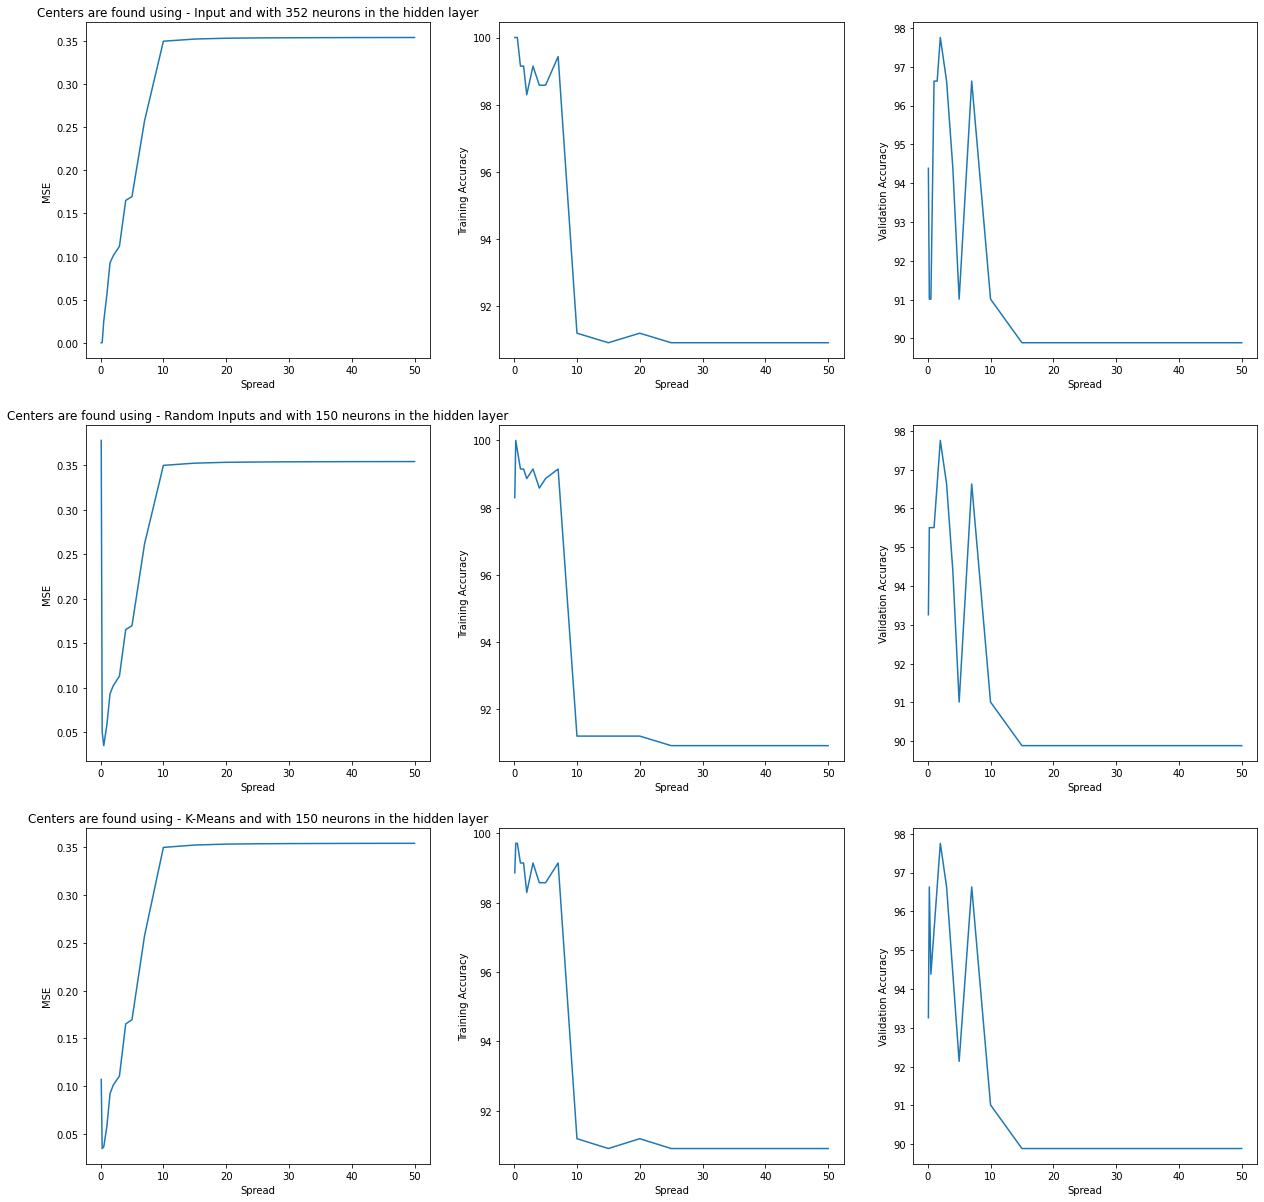

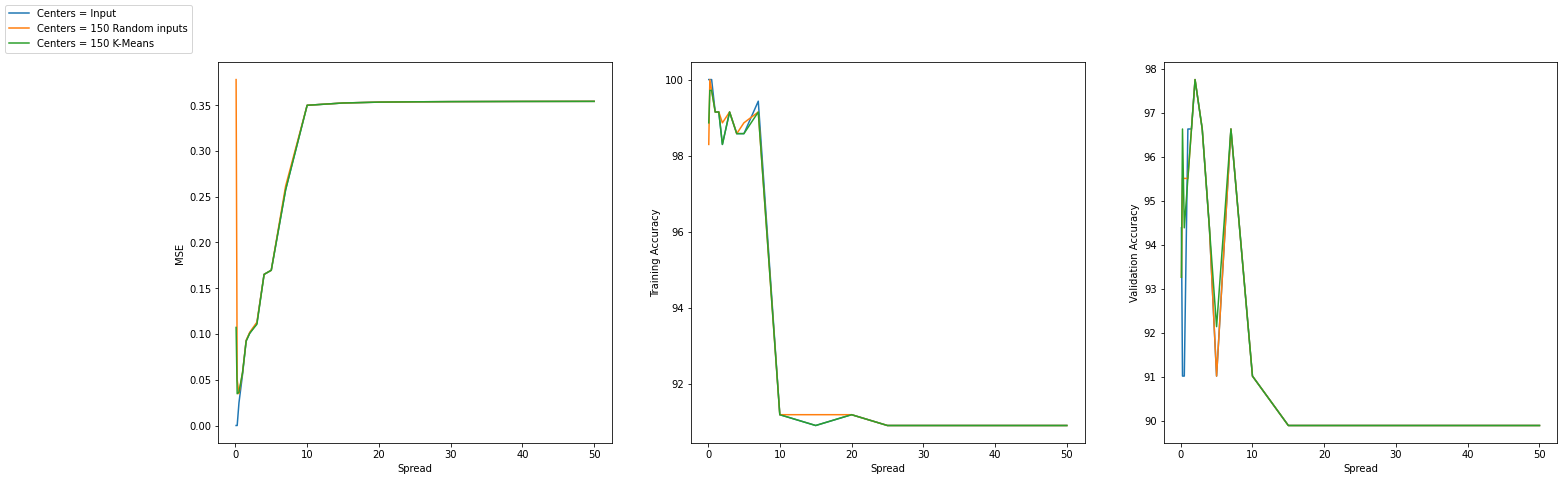

In [92]:
# -------------- Prepare Input Data for the network -----------------
a = assignment(center_methods = ["Input", "Random Inputs", "K-Means"], spreads = [0.1, 0.25, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 40, 50], test_validation_division = 8/10)
a.generate_input_data()
a.train_and_observe()

#### Class Example

In [93]:
# test_input_set = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype = float)
# test_label_set = np.array([-1, 1, 1, -1], dtype = float)

# rbf = RBF_Neural_Nw(size_input_features = 2, size_hidden = 2, size_out = 1, radial_function = "Gaussian Kernel", loss_function = "Mean Square Error", spread = 1, center_method = "Class Example")
# loss, accuracy_predictions_test, accuracy_predictions_valid = rbf.build_Model(test_input_set, test_input_set, test_label_set, test_label_set)

# print(rbf.G)
# print(rbf.weights)
# print(rbf.actual_out)
